In [1]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql.functions as sparkfunc

matplotlib.rcParams['figure.dpi'] = 120

from dustmaps.sfd import SFDQuery

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.master', "local[8]") \
                            .config('spark.memory.offHeap.enabled', 'true') \
                            .config('spark.memory.offHeap.size', '16G') \
                            .config('spark.driver.memory', '16G') \
                            .config("spark.sql.execution.arrow.enabled", "true").getOrCreate()

In [3]:
gaia_ = spark.read.load("/epyc/data/gaia_dr2_1am_dup/")
gaia = gaia_.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia_['source_id']/34359738368))

In [22]:
%%time

sfd_order = 9
sfd = SFDQuery()
npix = hp.nside2npix(hp.order2nside(sfd_order))

angle_theta, angle_phi = hp.pix2ang(hp.order2nside(sfd_order), np.arange(npix), nest=True)

reddening = sfd.query_equ(np.rad2deg(angle_phi), 90.0 - np.rad2deg(angle_theta))

EBV_map_hpix12 = hp.ud_grade(reddening, hp.order2nside(12), order_in='NEST')
pandas_df = pd.DataFrame({"hpix12": np.arange(len(EBV_map_hpix12)),
                                             "EBV": EBV_map_hpix12})

reddening_df = spark.createDataFrame(pandas_df)

CPU times: user 14.5 s, sys: 36.7 s, total: 51.2 s
Wall time: 38.3 s


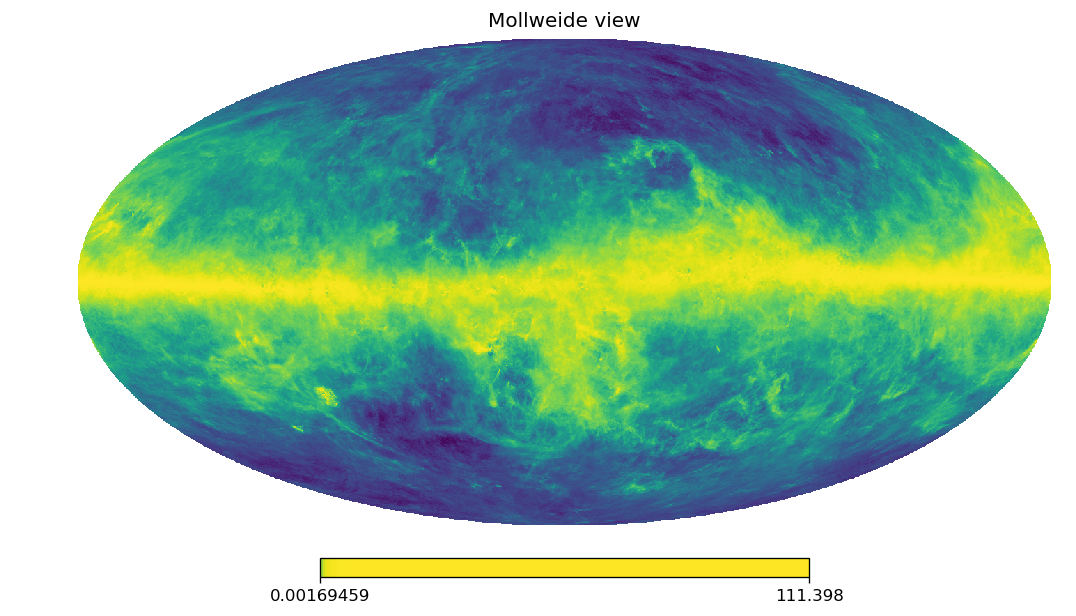

In [23]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(EBV_map_hpix12, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

In [24]:
%%time
gaia_w_EBV = gaia.join(reddening_df, on="hpix12")

CPU times: user 1.89 ms, sys: 5.43 ms, total: 7.32 ms
Wall time: 39.1 ms


In [25]:
%%time
gaia_g0 = gaia_w_EBV.withColumn("phot_g0", gaia_w_EBV['phot_g_mean_mag'] - 3.1*gaia_w_EBV['EBV']).\
                      withColumn("bp_rp_0", gaia_w_EBV['bp_rp'] - 1.2919*gaia_w_EBV['EBV'])

#
# .cache() will make this horribly horribly slow!!
#
#gaia_g0.cache()
#gaia_g0.count()

CPU times: user 3.06 ms, sys: 3.72 ms, total: 6.78 ms
Wall time: 140 ms


In [7]:
from gaia_tools import healpix_hist, bin_column


In [26]:
%%time
dereddened_density2 = healpix_hist(gaia_g0. \
                                  where((gaia_g0['dup'] == 0) &
                                        (gaia_g0['bp_rp_0'] > 0.3) & (gaia_g0['bp_rp_0'] < 0.8) &
                                        (gaia_g0['phot_g0'] > 16) & (gaia_g0['phot_g0'] <= 19)),
                                   NSIDE=512, agg={"hpix__": "count"})

CPU times: user 147 ms, sys: 211 ms, total: 358 ms
Wall time: 6min 41s


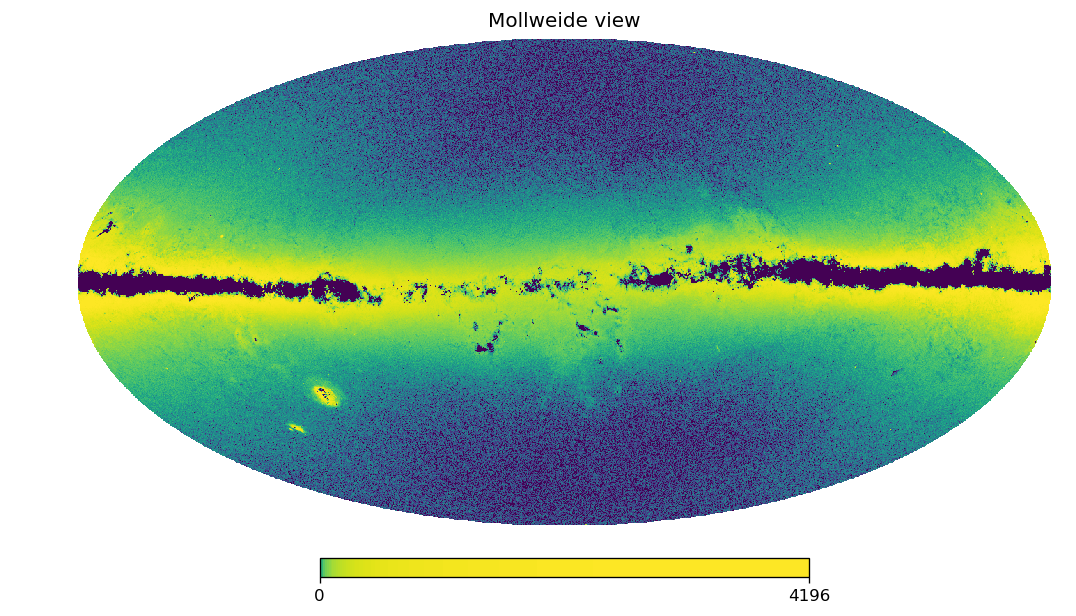

In [27]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(dereddened_density2, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')